Optimizing Equipment Performance through Predictive Maintenance Strategies

In [4]:
# Importing librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

In [5]:
# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importing the dataset
url = 'https://raw.githubusercontent.com/kueyram/Predictive-Maintenance/refs/heads/main/data/machine_failure.csv'

# Reading the dataset into pandas
pred_maintenance_df = pd.read_csv(url, sep=',')

# Printing the columns of the dataset
pred_maintenance_df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

In [7]:
# Let's inspect the dataset and check its structure and contents
pred_maintenance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 703.3+ KB


In [8]:
pred_maintenance_df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [9]:
# Printing 5 random columns from the dataset
pred_maintenance_df.sample(n=5)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
4062,L51242,L,302.0,310.9,1446,44.0,64,0,No Failure
6882,L54062,L,300.9,311.4,2073,21.4,105,0,No Failure
1038,L48218,L,296.6,307.6,1498,41.1,80,0,No Failure
8387,L55567,L,298.8,309.9,1351,47.2,73,0,No Failure
1022,L48202,L,296.2,307.2,1515,36.5,38,0,No Failure


In [10]:
# Let's check for duplicates

# Checking for duplicates across all columns
duplicates = pred_maintenance_df[pred_maintenance_df.duplicated()]

# Checking if duplicates dataframe is empty
if duplicates.empty:
    print("No duplicates found.")
else:
    print("Duplicates found:")
    print(duplicates)

No duplicates found.


In [11]:
# Checking for missing values

missing_values = pred_maintenance_df.isnull().any()

# Checking if any column contains NaN
if missing_values.any():
    print("NaN values found in the following columns:")
    print(missing_values[missing_values].index.tolist())
else:
    print("No missing values found in the Dataset.")

No missing values found in the Dataset.


Creating visualizations

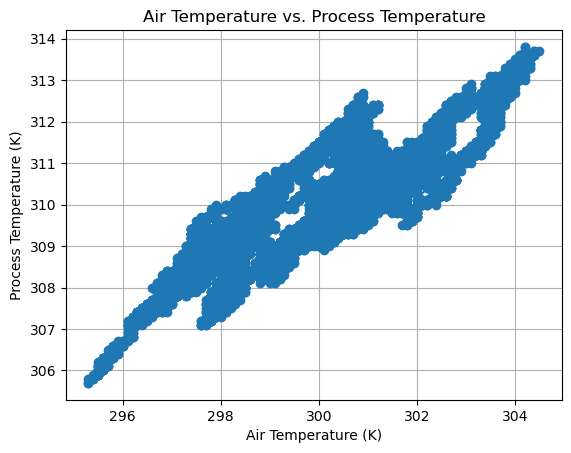

In [12]:
# Let's extract the columns we need for the chart
air_temperature = pred_maintenance_df['Air temperature [K]']
process_temperature = pred_maintenance_df['Process temperature [K]']

# Line chart
plt.plot(air_temperature, process_temperature, marker='o')
plt.xlabel('Air Temperature (K)')
plt.ylabel('Process Temperature (K)')
plt.title('Air Temperature vs. Process Temperature')
plt.grid(True)
plt.show()

The chart shows that there is a positive correlation between the air temperature and the process temperature. We can conclude that environmental factors have impacts on the operations.

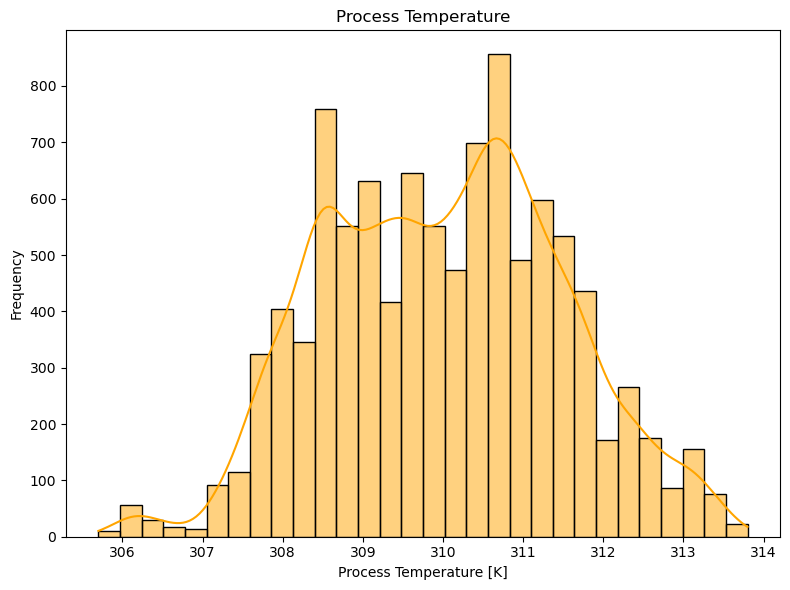

In [13]:
# Creating the histogram for Process Temperature
plt.figure(figsize=(8, 6))
sns.histplot(pred_maintenance_df['Process temperature [K]'], bins=30, kde=True, color='orange')
plt.xlabel('Process Temperature [K]')
plt.ylabel('Frequency')
plt.title('Process Temperature')
plt.tight_layout()
plt.show()

The process Temperature is normally distributed

In [14]:
# Removing columns not needed
# To predict maintenance, we do not need Product ID. Therefore, we are dropping the columns

# Removing the 'Product ID' column
pred_maintenance_df.drop(['Product ID'], axis=1, inplace=True)

# Print list of columns
pred_maintenance_df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

Feature transformation: We will convert Air temperature and Process temperature from Kelvin to Fahrenheit

In [15]:
# Function to convert temperature from kelvin to Fahrenheit
def kelvin_to_f(temperature_kelvin):
    temperature_f = ((temperature_kelvin-273.15)*9/5)+32
    return temperature_f

# Let's create a new columns called Air temperature [F]
pred_maintenance_df['Air temperature [F]'] = pred_maintenance_df['Air temperature [K]'].apply(kelvin_to_f)

# Let's create a new columns called Process temperature [F]
pred_maintenance_df['Process temperature [F]'] = pred_maintenance_df['Process temperature [K]'].apply(kelvin_to_f)

# Let's now drop the columns 'Air temperature [K]' and Process temperature [K]
pred_maintenance_df.drop(['Air temperature [K]', 'Process temperature [K]'], axis=1, inplace=True)

# Printing the first 5 rows of the dataset
pred_maintenance_df.head(5)

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F]
0,M,1551,42.8,0,0,No Failure,76.91,95.81
1,L,1408,46.3,3,0,No Failure,77.09,95.99
2,L,1498,49.4,5,0,No Failure,76.91,95.63
3,L,1433,39.5,7,0,No Failure,77.09,95.81
4,L,1408,40.0,9,0,No Failure,77.09,95.99


Scaling the numerical columns using MinMaxScaler

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Columns to scale
numeric_columns = ['Process temperature [F]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air temperature [F]']

# Fitting the scaler
scaler.fit(pred_maintenance_df[numeric_columns])

# Transforming the columns usinf the fitted scaler
pred_maintenance_df[numeric_columns] = scaler.transform(pred_maintenance_df[numeric_columns])

# Printing the first 5 rows of the dataset
pred_maintenance_df.head(5)

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F]
0,M,0.222934,0.535714,0.000000,0,No Failure,0.304348,0.358025
1,L,0.139697,0.583791,0.011858,0,No Failure,0.315217,0.370370
2,L,0.192084,0.626374,0.019763,0,No Failure,0.304348,0.345679
3,L,0.154249,0.490385,0.027668,0,No Failure,0.315217,0.358025
4,L,0.139697,0.497253,0.035573,0,No Failure,0.315217,0.370370


Creating new features:
- Power consumption: Energy used by equipment (rotational speed * torque)
- Temperature difference: Temperature variation between air temperature and process temperature
- Temperature ratio: Relationship between air temperature and process temperature   

In [17]:
# Power consumption
pred_maintenance_df['Power consumption [W]'] = pred_maintenance_df['Rotational speed [rpm]'] * pred_maintenance_df['Torque [Nm]']

# Difference between temperatures
pred_maintenance_df['Temperature difference [F]'] = pred_maintenance_df['Air temperature [F]'] - pred_maintenance_df['Process temperature [F]']

# Ratio of temperatures
pred_maintenance_df['Temperature ratio'] = pred_maintenance_df['Air temperature [F]'] / pred_maintenance_df['Process temperature [F]']

# Printing the first 5 rows of the dataset
pred_maintenance_df.head(5)

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F],Power consumption [W],Temperature difference [F],Temperature ratio
0,M,0.222934,0.535714,0.000000,0,No Failure,0.304348,0.358025,0.119429,-0.053677,0.850075
1,L,0.139697,0.583791,0.011858,0,No Failure,0.315217,0.370370,0.081554,-0.055153,0.851087
2,L,0.192084,0.626374,0.019763,0,No Failure,0.304348,0.345679,0.120316,-0.041331,0.880435
3,L,0.154249,0.490385,0.027668,0,No Failure,0.315217,0.358025,0.075641,-0.042807,0.880435
4,L,0.139697,0.497253,0.035573,0,No Failure,0.315217,0.370370,0.069465,-0.055153,0.851087


In [18]:
# Checking for missing values
missing_values = pred_maintenance_df.isnull()
total_missing_per_column = missing_values.sum()
print(total_missing_per_column)

Type                          0
Rotational speed [rpm]        0
Torque [Nm]                   0
Tool wear [min]               0
Target                        0
Failure Type                  0
Air temperature [F]           0
Process temperature [F]       0
Power consumption [W]         0
Temperature difference [F]    0
Temperature ratio             2
dtype: int64


The columns Temperature ration has 2 missing values

In [19]:
# Finding rows with missing values
rows_with_missing_values = pred_maintenance_df[pred_maintenance_df.isnull().any(axis=1)]

# Printing rows with missing values
rows_with_missing_values

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F],Power consumption [W],Temperature difference [F],Temperature ratio
917,L,0.178696,0.648352,0.739130,0,No Failure,0.0,0.0,0.115858,0.0,NaN
918,M,0.177532,0.476648,0.747036,0,No Failure,0.0,0.0,0.084620,0.0,NaN


In [20]:
# Replacing the  NaN values with 0
pred_maintenance_df['Temperature ratio'].fillna(0, inplace=True)

##### Creating dummy variables
The columns Type is a categorical columns and has different values. We will create dummy variables for the Type column. This will help the model to understand the categorical relationship between the product Type and potential failures.

In [21]:
# Creating dummy variables for Type
dummy_variables = pd.get_dummies(pred_maintenance_df['Type'], prefix='Type')

# Let's concatenate the dummy variables with the dataset
predictive_maintenance_with_dummies = pd.concat([pred_maintenance_df, dummy_variables], axis=1)

In [22]:
# Printing the first few rows of the new dataset
predictive_maintenance_with_dummies.head(5)

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F],Power consumption [W],Temperature difference [F],Temperature ratio,Type_H,Type_L,Type_M
0,M,0.222934,0.535714,0.000000,0,No Failure,0.304348,0.358025,0.119429,-0.053677,0.850075,False,False,True
1,L,0.139697,0.583791,0.011858,0,No Failure,0.315217,0.370370,0.081554,-0.055153,0.851087,False,True,False
2,L,0.192084,0.626374,0.019763,0,No Failure,0.304348,0.345679,0.120316,-0.041331,0.880435,False,True,False
3,L,0.154249,0.490385,0.027668,0,No Failure,0.315217,0.358025,0.075641,-0.042807,0.880435,False,True,False
4,L,0.139697,0.497253,0.035573,0,No Failure,0.315217,0.370370,0.069465,-0.055153,0.851087,False,True,False


In [23]:
predictive_maintenance_with_dummies.head(5)

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [F],Process temperature [F],Power consumption [W],Temperature difference [F],Temperature ratio,Type_H,Type_L,Type_M
0,M,0.222934,0.535714,0.000000,0,No Failure,0.304348,0.358025,0.119429,-0.053677,0.850075,False,False,True
1,L,0.139697,0.583791,0.011858,0,No Failure,0.315217,0.370370,0.081554,-0.055153,0.851087,False,True,False
2,L,0.192084,0.626374,0.019763,0,No Failure,0.304348,0.345679,0.120316,-0.041331,0.880435,False,True,False
3,L,0.154249,0.490385,0.027668,0,No Failure,0.315217,0.358025,0.075641,-0.042807,0.880435,False,True,False
4,L,0.139697,0.497253,0.035573,0,No Failure,0.315217,0.370370,0.069465,-0.055153,0.851087,False,True,False


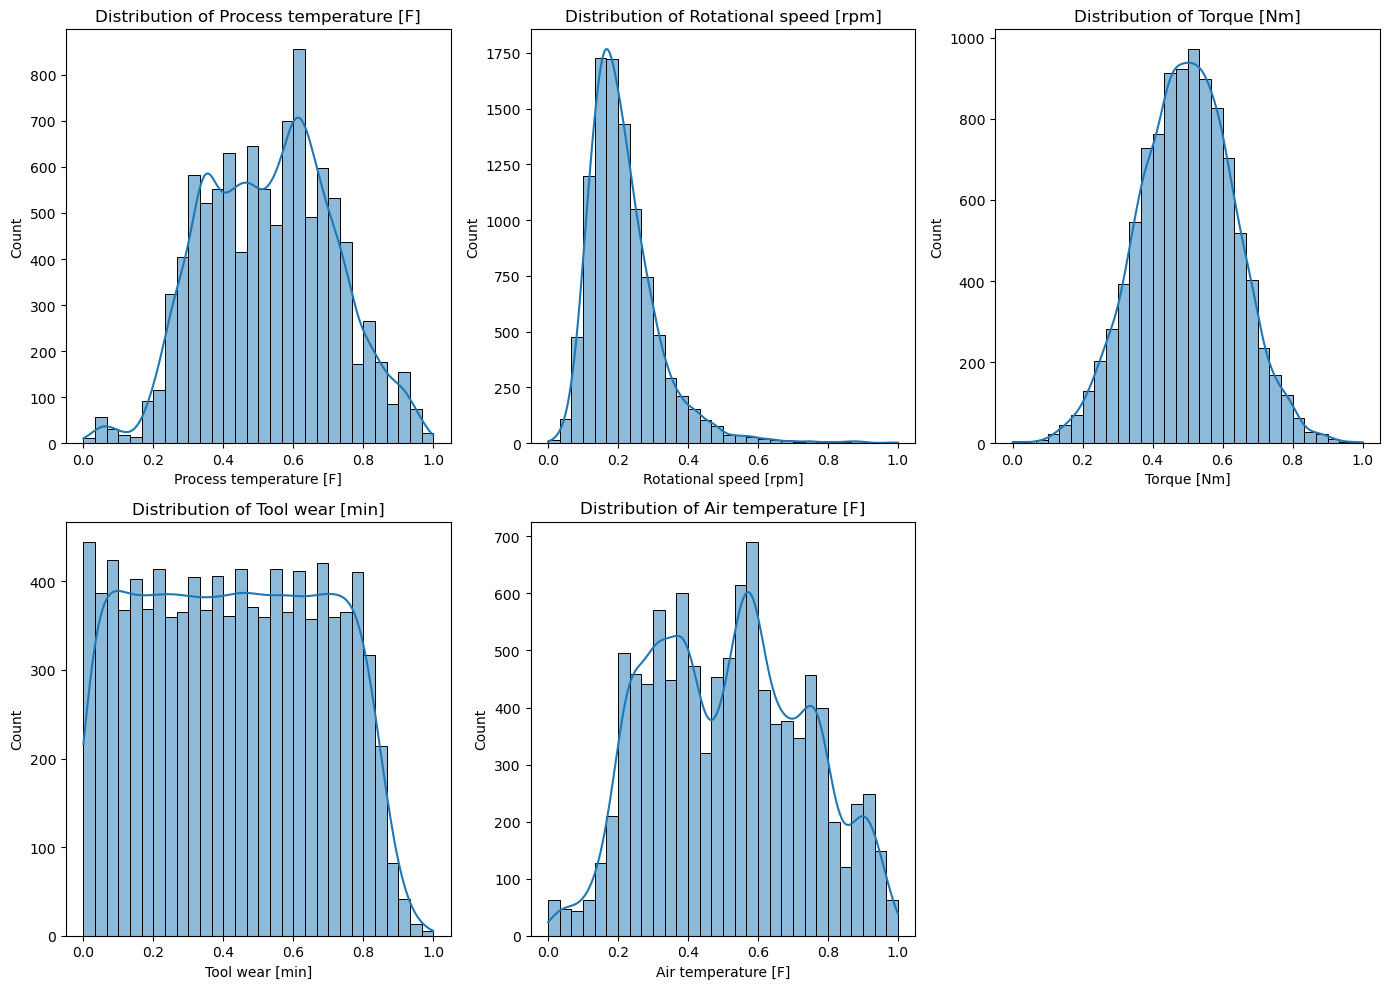

In [24]:
# Distribution of key features
plt.figure(figsize=(14, 10))
features = ['Process temperature [F]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air temperature [F]']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(pred_maintenance_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

These graphs shows that the key features are relatively normally distributed

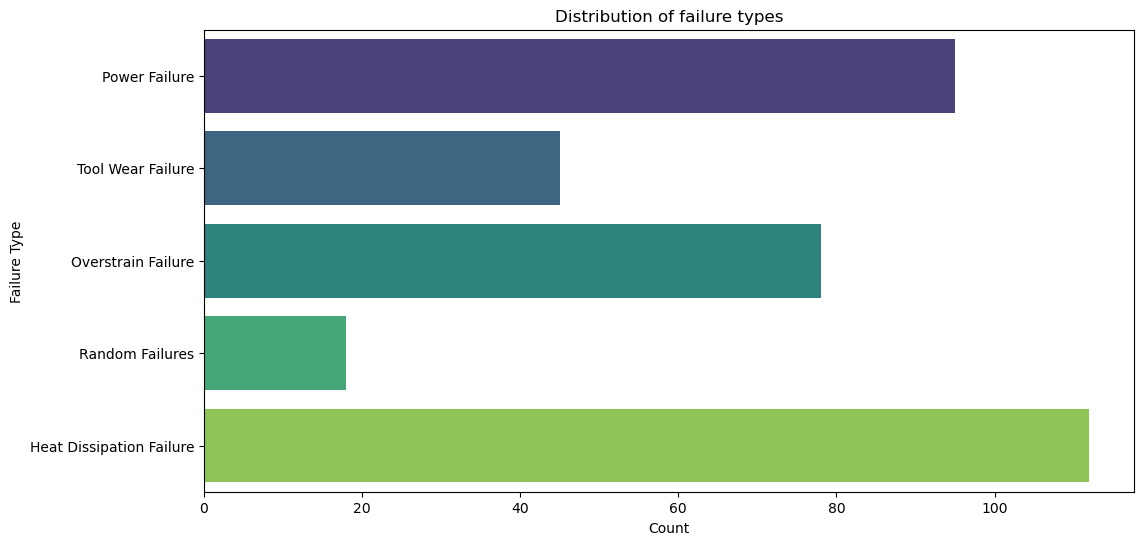

In [25]:
# Filtering the dataset to exclude "No Failure"
filtered_df = pred_maintenance_df[pred_maintenance_df['Failure Type'] != 'No Failure']

# Creating a horizontal bar chart for the filtered data
plt.figure(figsize=(12, 6))
sns.countplot(y='Failure Type', data=filtered_df, palette='viridis')
plt.title('Distribution of failure types')
plt.xlabel('Count')
plt.ylabel('Failure Type')
plt.show()

The graph shows that Power and heat Dissipation are the main causes of equipment failure.

#### Creating the models
We are going to build a two-stage model. We will first predict wether or not a failure will occure and then if a failure occurs, we will predict the type
Let's add a new column called Failure. Its value will be 0 if No Failure and 1 otherwise

In [26]:
pred_maintenance_df['Failure'] = pred_maintenance_df['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)

We want to be able to predict if a failure will occur and what type of failure. We will use a combination of Logistic Regression for binary classification (failure/non-failure) and Random Forest for multiclass classification (failure types). Logistic regression will help us with the probability of failure and the Random Forest will help with predicting the type of failures

In [27]:
# Let's drop the target columns before creating the dummy variables
pred_maintenance_df_dropped = pred_maintenance_df.drop(columns=['Failure Type', 'Failure'])

# Let's convert categorical variables to dummy variables
pred_maintenance_df_converted = pd.get_dummies(pred_maintenance_df_dropped)

In [28]:
pred_maintenance_df.columns

Index(['Type', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Target', 'Failure Type', 'Air temperature [F]',
       'Process temperature [F]', 'Power consumption [W]',
       'Temperature difference [F]', 'Temperature ratio', 'Failure'],
      dtype='object')

In [29]:
# Features and target
features = pred_maintenance_df_converted
target = pred_maintenance_df['Failure']

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=0)

Logistic Regression

In [31]:
# Let's initialize and train a logistic regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(features_train, target_train)

# Let's predict and evaluate our model
logreg_predictions = logreg_model.predict(features_test)

print("Logistic Regression")
print(classification_report(target_test, logreg_predictions))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1927
           1       0.93      0.96      0.95        73

    accuracy                           1.00      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       1.00      1.00      1.00      2000



In [32]:
# Let's calculate the accuracy
accuracy = accuracy_score(target_test, logreg_predictions)
# Printing the accuracy
print("Accuracy:", accuracy)

# Precision
precision = precision_score(target_test, logreg_predictions, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(target_test, logreg_predictions, average='weighted')
print("Recall:", recall)

#F1-Score
f1 = f1_score(target_test, logreg_predictions, average='weighted')
print("F1-Score:", f1)

Accuracy: 0.996
Precision: 0.9960651082251083
Recall: 0.996
F1-Score: 0.9960259886054278


Multiclass Classification

In [33]:
# Let's define the target for the multiclass classification
target_multiclass = pred_maintenance_df['Failure Type']

# SPlitting the data
features_train_mc, features_test_mc, target_train_mc, target_test_mc = train_test_split(features, target_multiclass, test_size=0.2, random_state=0)

In [34]:
# Let's train and evaluate a random forest model RFM
from sklearn.ensemble import RandomForestClassifier

# Initilization
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(features_train_mc, target_train_mc)

# Prediction and evaluating the model
rf_predictions = rf_model.predict(features_test_mc)
print("Random Forest Model")
print(classification_report(target_test_mc, rf_predictions))

Random Forest Model
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      1.00      0.98        21
              No Failure       1.00      1.00      1.00      1927
      Overstrain Failure       0.86      0.90      0.88        21
           Power Failure       0.74      0.94      0.83        18
         Random Failures       0.00      0.00      0.00         3
       Tool Wear Failure       1.00      0.80      0.89        10

                accuracy                           0.99      2000
               macro avg       0.76      0.77      0.76      2000
            weighted avg       0.99      0.99      0.99      2000



In [35]:
# Extracting feature importances
importances = rf_model.feature_importances_

# Creating a dataframe for the feature importances
feature_names = features.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

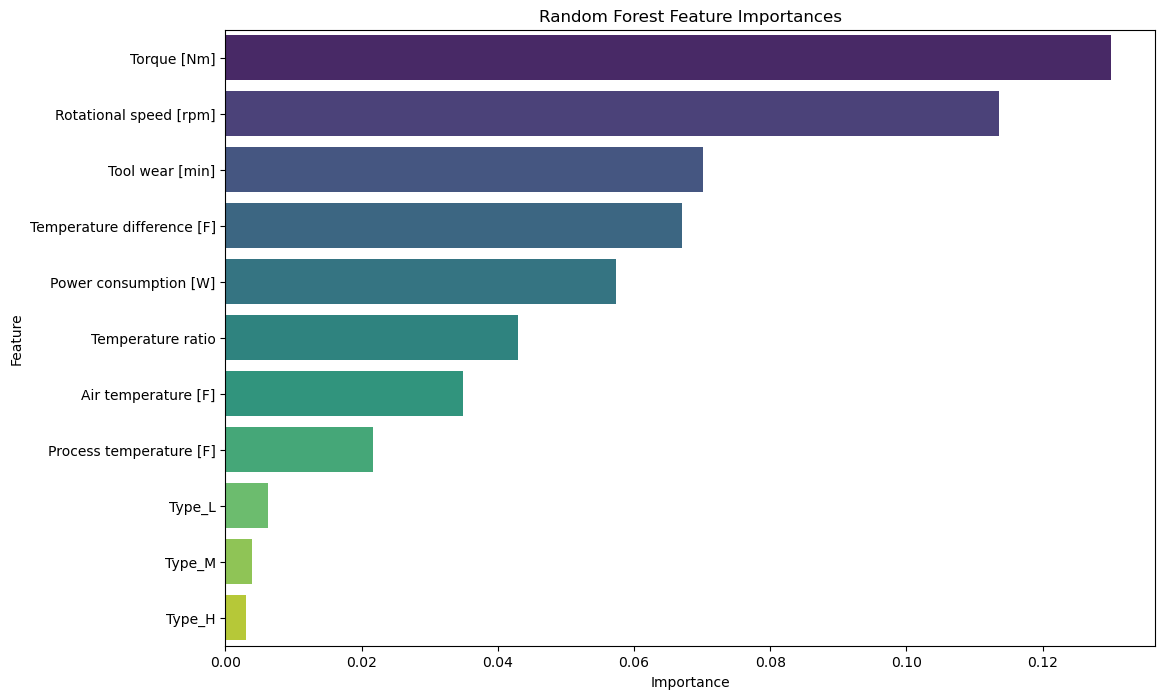

In [36]:
# Graph of the feature importance
importance_df_no_target = importance_df[importance_df['Feature'] != 'Target']

# Plotting the filtered feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_no_target, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [37]:
# Making predictions with the Random Forest model
rf_predictions = rf_model.predict(features_test_mc)

# Calculate Accuracy
rf_accuracy = accuracy_score(target_test_mc, rf_predictions)
print("Accuracy:", rf_accuracy)

# Precision
rf_precision = precision_score(target_test_mc, rf_predictions, average='macro')
print("Precision:", rf_precision)

# Recall
rf_recall = recall_score(target_test_mc, rf_predictions, average='macro')
print("Recall:", rf_recall)

# F1-score
rf_f1 = f1_score(target_test_mc, rf_predictions, average='macro')
print("F1-Score:", rf_f1)


Accuracy: 0.9935
Precision: 0.7592923019009975
Recall: 0.7744352737347029
F1-Score: 0.7627575757754245
